In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st

#Save
import json
import scipy.io as sio
import h5py
import io_dict_to_hdf5 as ioh5

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# cmap = usrplt.gradient_cmap(usrplt.color_palette)
sns.set_style("ticks")

#Model
import ssm

#User
import util
import plotting as usrplt


In [9]:
D = 6
K = 12
lags = 3

In [11]:
test2 = .80 * np.array([np.column_stack([ssm.util.random_rotation(D), np.zeros((D, (lags-1) * D))])
            for _ in range(K)])

test2.shape

(12, 6, 18)

In [57]:
3/60

0.05

In [60]:
2/20

0.1

In [49]:
#DLC tracking confidence threshold at which to mask out data
confidence_threshold = 0.8
dsf = 3
#Loop over trials and reformat data for ARHMM
data_list_ds = []; mask_list_ds = []
for iTrial in range(nTrials):
    #Get coordinates of Take-Off platform
    xc = np.nanmean(data_df.loc[iTrial]['Side TakeFL x'])
    yc = np.nanmean(data_df.loc[iTrial]['Side TakeFL y'])
    
    xy_list = []; ll_list = []
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        x = data_df.loc[iTrial]['Side {} x'.format(ptstr)]
        y = data_df.loc[iTrial]['Side {} y'.format(ptstr)]
        llhood = data_df.loc[iTrial]['Side {} likelihood'.format(ptstr)]
        
        #Coordinates relative to take-off platform
        xy_list.append((x-xc,y-yc))
        
        #Create mask for points that have a confidence lower than the given threshold
        mask = llhood > confidence_threshold
        ll_list.append((mask,mask))
    
    tmp = np.vstack(xy_list)[:,2:-2].T; data_list_ds.append(tmp[:-1:dsf,:])
    tmp = np.vstack(ll_list)[:,2:-2].T; mask_list_ds.append(tmp[:-1:dsf,:])
#     pdb.set_trace()



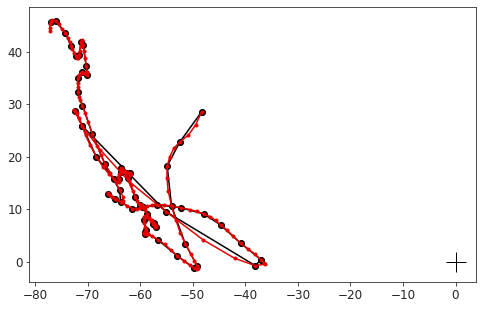

In [64]:
##===== Let's look at the states! =====##
iTrial = 45


data = data_list[iTrial]
data_ds = data_list_ds[iTrial]

fig, ax = plt.subplots(figsize=(8,8))


ax.plot(data_ds[:,0],data_ds[:,1],'o-k')
ax.plot(data[:,0],data[:,1],'.-',color=usrplt.cc[1])

ax.plot(0,0,'+k',ms=20)
ax.set_aspect('equal', adjustable='box',share=True)
# ax.set_xlim([-75,75])
# ax.set_ylim([-75,75])


In [ ]:
##===== Fit ARHMM to data =====##
_, dObs = data_list[0].shape

#HMM parameters
#Let's start with 10 states
K = 12
N_iters=200

#Initialize basic ARHMM object 
#lots of parameters we can change; 
# we can make the transitions sticky or change the probability of transition given some external input;
# we can also change the observation class to "robust_autoregressive", which 
arhmm = ssm.HMM(K, dObs, transitions='sticky', transition_kwargs={'kappa': 5E5}, observations="autoregressive",observation_kwargs={'lags': 2}) 

#Fit model to data
hmm_lls = arhmm.fit(data_list_ds, method="em", num_iters=N_iters,tolerance=1E-6)

In [14]:
color_names_K = usrplt.color_names[:K]; color_names_K.append(usrplt.color_names[-1])
color_palette = sns.xkcd_palette(color_names_K)
cmap = usrplt.gradient_cmap(sns.xkcd_palette(usrplt.color_names[:K]))

In [15]:
#Loop over trials and get the maximum a posteriori probability estimate of the latent states
MAP_list = []; posterior_list = []; mask_list = []

for data in data_list:
    expected_states, expected_joints, log_likes = arhmm.expected_states(data)

    MAP_list.append(np.argmax(expected_states,axis=1))
    posterior_list.append(expected_states)
    mask_list.append(np.max(expected_states,axis=1) > 0.8)


In [ ]:
##===== Save state sequences =====##
ioh5.save('./results/preparatory_behavior_K-{}_ARHMM.h5'.format(K), {'MAP_list':MAP_list, 'posterior_list':posterior_list,'mask_list': mask_list})

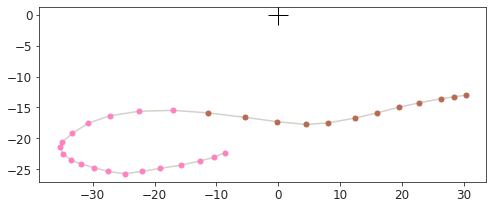

In [48]:
##===== Let's look at the states! =====##
iTrial = 10
mapseq = MAP_list[iTrial]
data = data_list[iTrial]

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(data_list[iTrial][:,0],data_list[iTrial][:,1],'-',color=usrplt.cc[-1],alpha=0.5)
# ax.plot(data_list[iTrial][:,2],data_list[iTrial][:,3],'-',color=usrplt.cc[-1],alpha=0.5)
# ax.plot(data_list[iTrial][:,4],data_list[iTrial][:,5],'-',color=usrplt.cc[-1],alpha=0.5)

for state in np.unique(mapseq):
    indy = np.where(mapseq == state)[0]
    #Plot traces
    ax.plot(data[indy,0],data[indy,1],'.',color=usrplt.cc[state],ms=10)
#     ax.plot(data[indy,2],data[indy,3],'.',color=usrplt.cc[state],ms=10)
#     ax.plot(data[indy,4],data[indy,5],'.',color=usrplt.cc[state],ms=10)

ax.plot(0,0,'+k',ms=20)
ax.set_aspect('equal', adjustable='box',share=True)
# ax.set_xlim([-75,75])
# ax.set_ylim([-75,75])


In [ ]:
data_df.head()


In [ ]:
np.unique(data_df['distance'],return_counts=True)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [ ]:
indy_dict = data_df.groupby(['distance','success']).indices
for k in indy_dict.keys():
    print('Distance: {:02d}: -> Success: {} \t {:3d} trials'.format(*k,len(indy_dict[k])))

In [ ]:
TCMs = util.get_transition_count_matrices(MAP_list, mask_list, K)

In [ ]:
print('Test: {:.0e}'.format(1E6))

In [ ]:
indy_dict = data_df.groupby(['subject','distance']).indices
mouse_IDs = np.unique(data_df['subject'])
distances = np.unique(data_df['distance'])

for mID in mouse_IDs:
    fig, axes = plt.subplots(1,5,figsize=(24,4),sharey=True)
    plt.suptitle('Mouse {}'.format(mID),y=1.05,fontsize=20)
    
    tmp_list = []
    for iD, dist in enumerate(distances):
        trial_indices = indy_dict[(mID,dist)]
        
#         TCMs_subset = TCMs[trial_indices]
        TCMs_subset = np.sum(TCMs[trial_indices],axis=0)
        TCMs_norm = TCMs_subset/np.sum(TCMs_subset)
        tmp_list.append(TCMs_norm)
        
        ## Calculate state duration and state usage for this subset of the data
        state_duration_list, state_startend_list, state_usage = util.get_state_durations(MAP_list, mask_list, K,trial_indices)
        usrplt.plot_state_usage(state_usage,K,ax=axes[iD])
        axes[iD].set_title('Distance: {}'.format(dist))
        axes[iD].set_ylim([0,25])
#     mm = np.max(np.array(tmp_list)[:])
#     for iD, dist in enumerate(distances):
#         sns.heatmap(tmp_list[iD],square=True,vmax=mm,ax=axes[iD],cbar_kws={'shrink':0.75})
#         axes[iD].set_title('Distance: {}'.format(dist))
#     plt.show()
#     pdb.set_trace()
    

In [20]:
##===== Calculate state duration and state usage =====##
state_duration_list, state_startend_list, state_usage = util.get_state_durations(MAP_list, mask_list, K)

In [ ]:
#Plot
usrplt.plot_state_durations2(state_duration_list,state_usage, K)

In [ ]:
## Plot the actual AR matrices, with their corresponding fixed point
usrplt.plot_AR_matrices(arhmm)
    

In [ ]:
samp_rate

In [ ]:
dxdy = []
# What is the average distance between points?
for data in data_list:
    dxdy_nose_eye = [data[:,0]-data[:,2],data[:,1]-data[:,3]]
    dxdy_eye_ear = [data[:,2]-data[:,4],data[:,3]-data[:,5]]
    
    dxdy.append([np.mean(dxdy_nose_eye,axis=1),np.mean(dxdy_eye_ear,axis=1)])
average_dx_dy = np.mean(dxdy,axis=0)
average_dx_dy

In [ ]:
arhmm.D

ValueError: operands could not be broadcast together with shapes (6,6) (6,18) 

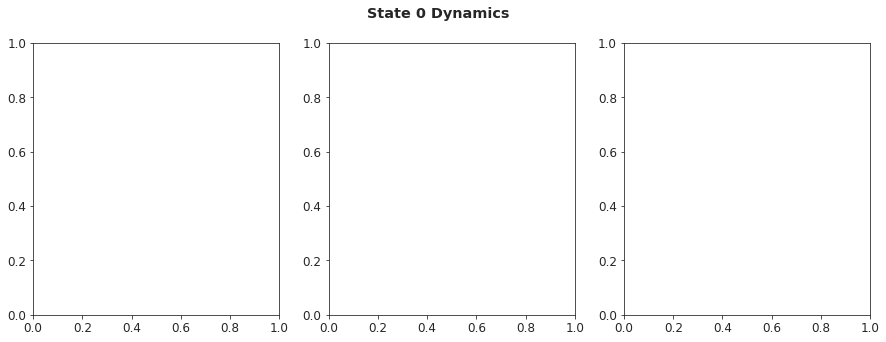

In [22]:
usrplt.plot_dynamics_2d(arhmm)

In [23]:
arhmm.observations.As[0].shape

(6, 18)

In [ ]:
mins=(-125,-125)
maxs=(125,125)
npts=35

##===== Let's visualize the dynamics of each state  =====## 
   

average_dx_dy = np.array([[-10.82328051,  10.58991895],[-12.93093803,  11.62390074]])
##===== Let's visualize the dynamics of each state  =====## 
for iState in range(K):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('State {} Dynamics'.format(iState))

    #Get AR process parameters
    AR = arhmm.observations.As[iState]
    bias = arhmm.observations.bs[iState]
    xstar = np.matmul(np.linalg.inv(np.eye(dObs)-AR),bias)
    
    #Create grid of points
    x_grid, y_grid = np.meshgrid(np.linspace(mins[0], maxs[0], npts), np.linspace(mins[1], maxs[1], npts))
    nX,nY = x_grid.shape
    xy_grid_nose = np.column_stack((x_grid.ravel(), y_grid.ravel(), np.zeros((npts**2,0))))
    #Using average distance between nose and eye, and eye and ear, create separate grids for those points
    xy_grid_leye = xy_grid_nose - average_dx_dy[0,:]
    xy_grid_lear = xy_grid_leye - average_dx_dy[1,:]
    xy_grid_3pts = np.hstack((xy_grid_nose,xy_grid_leye,xy_grid_lear))

    #Create delta grid
    dx = xy_grid_3pts.dot(AR.T) + bias - xy_grid_3pts
    dx = dx.reshape((nX,nY,-1))

    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        ax = axes[ii]

        #Calculate speed for linewidth
        speed = np.sqrt(dx[:,:,ii*2]**2 + dx[:,:,ii*2+1]**2)
        #Better than a quiver plot
        ax.streamplot(xy_grid_3pts[:,ii*2].reshape((nX,nY)), xy_grid_3pts[:,ii*2+1].reshape((nX,nY)), dx[:,:,ii*2], dx[:,:,ii*2+1],
                      color=cc[iState],arrowsize=1.25,arrowstyle='->',linewidth= 5*speed / speed.max())

#             ax.plot(xstar[2*ii],xstar[2*ii+1],'*k',ms=15)
        ax.set_title('Side {}'.format(ptstr))
        ax.set_xlim([-100,100]); ax.set_ylim([-100,100])
        ax.plot(0,0,'+k',ms=15)




In [ ]:
##===== Fit 2D gaussian to location where state is used =====##
state_locations = []


for state in range(K):
    tmp = []
    for data, mapseq in zip(data_list,MAP_list):
        indy = np.where(mapseq == state)[0]
        if len(indy) == 0:
            continue
        tmp.append(data[indy,:])
    
    state_locations.append(np.concatenate(tmp))

mlocations = []
for iState in range(K):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('Location of State {} usage'.format(iState))
    nBins, _ = state_locations[iState].shape
    sloc = state_locations[iState]
    if nBins < 5000:
        indy = np.arange(nBins)
    else:
        indy = np.random.randint(0, high=nBins, size=5000)
        
    tmp = []
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        ax = axes[ii]
        sns.kdeplot(x=sloc[indy,2*ii],y=sloc[indy,ii*2+1],color=usrplt.cc[iState],ax=ax)
        ax.plot(np.mean(sloc[indy,2*ii],axis=0),np.mean(sloc[indy,ii*2+1],axis=0),'xr')
        ax.set_title('Side {}'.format(ptstr))
        ax.plot(0,0,'+k',ms=15)
        ax.set_xlim([-100,100]); ax.set_ylim([-100,100])
    mlocations.append(tmp)
    
    
    

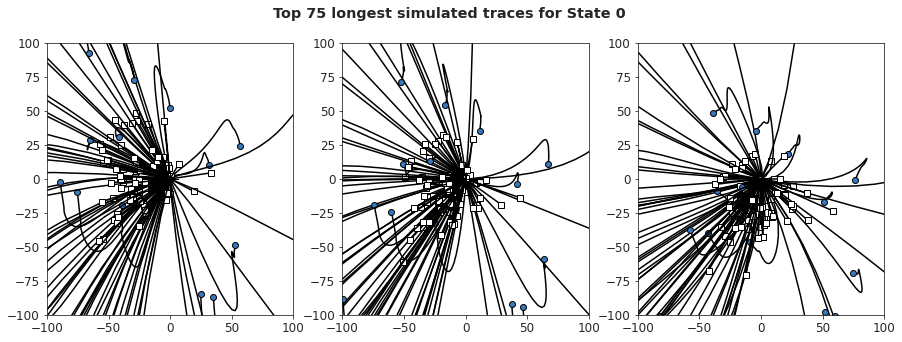

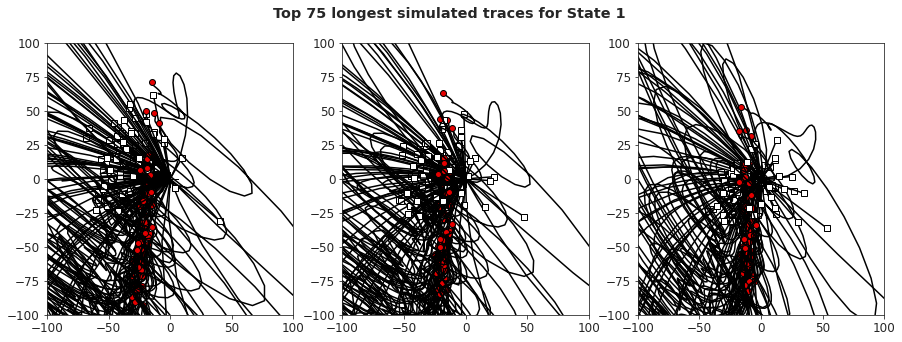

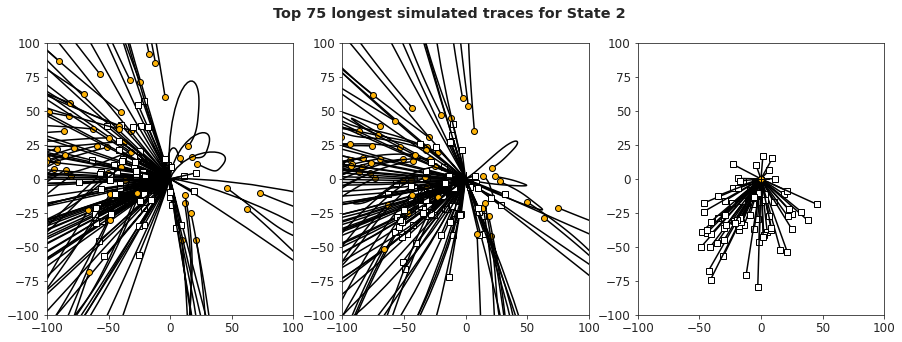

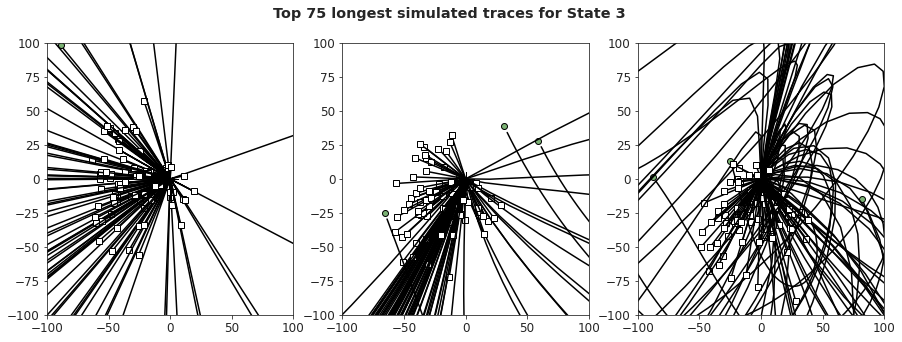

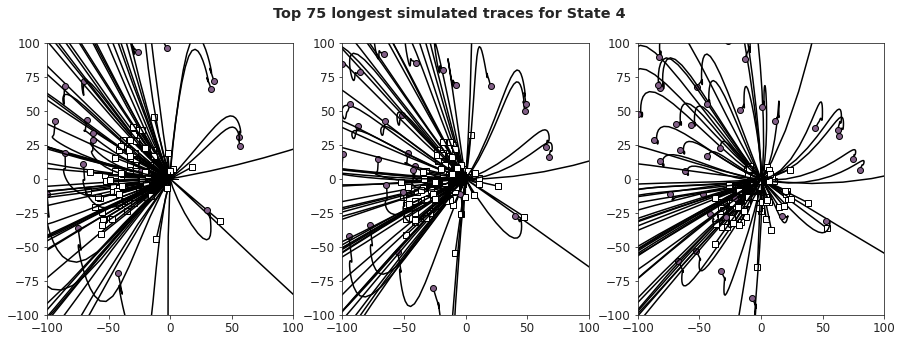

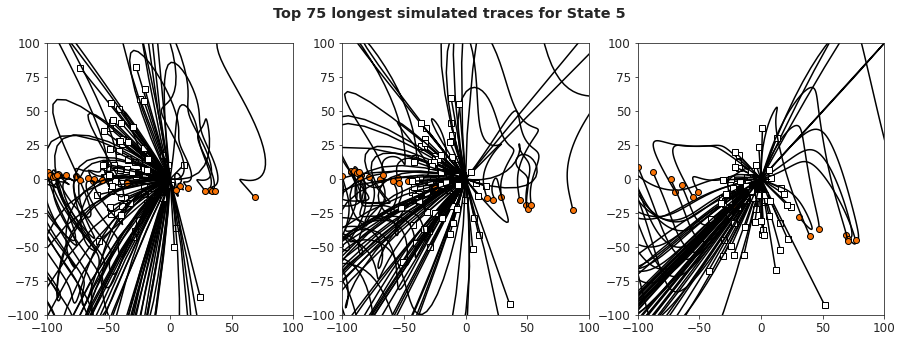

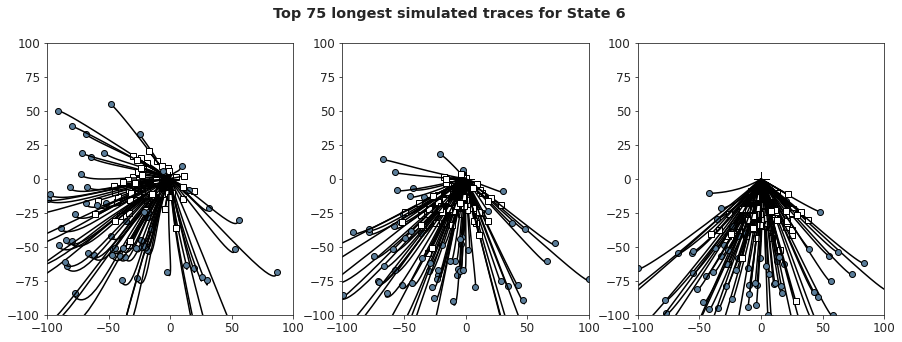

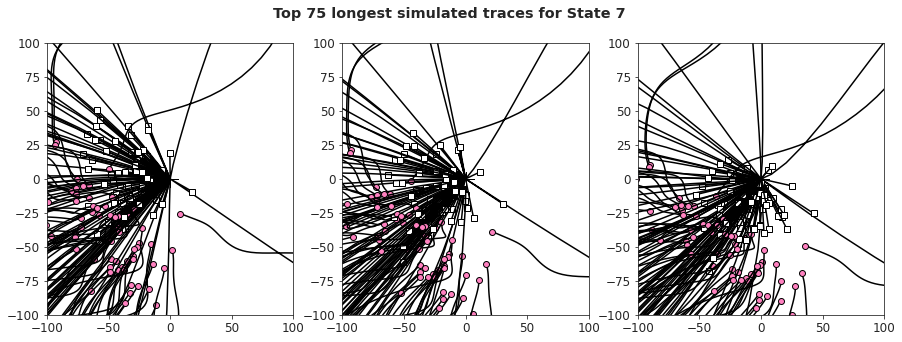

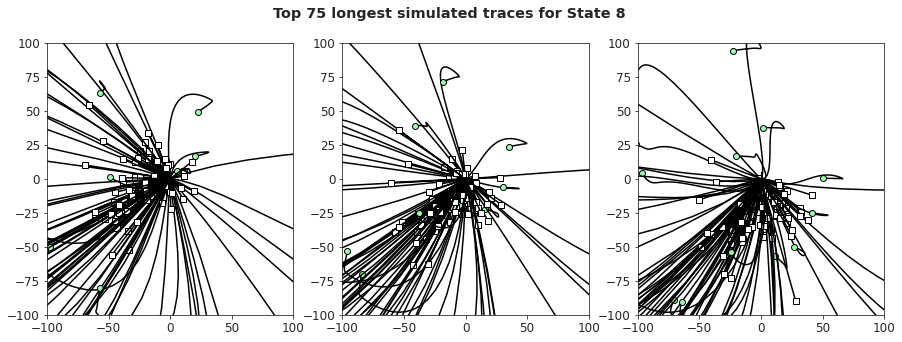

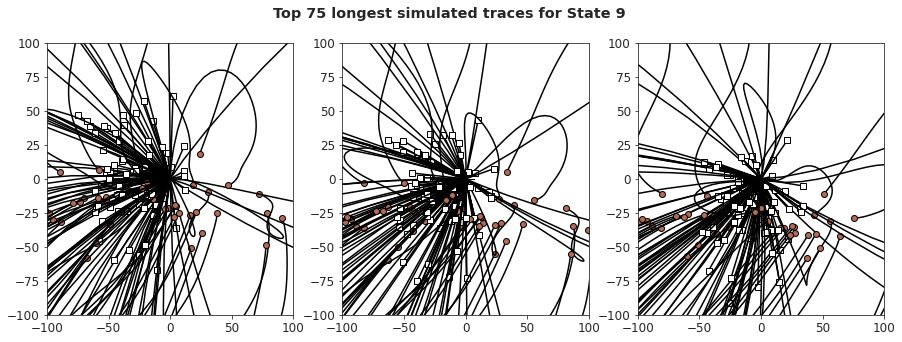

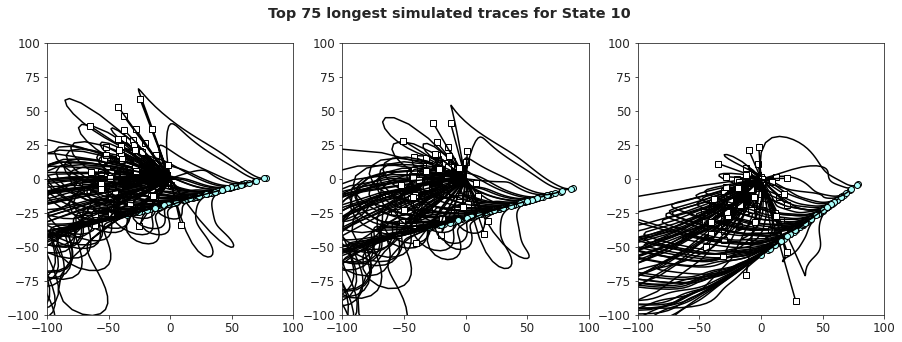

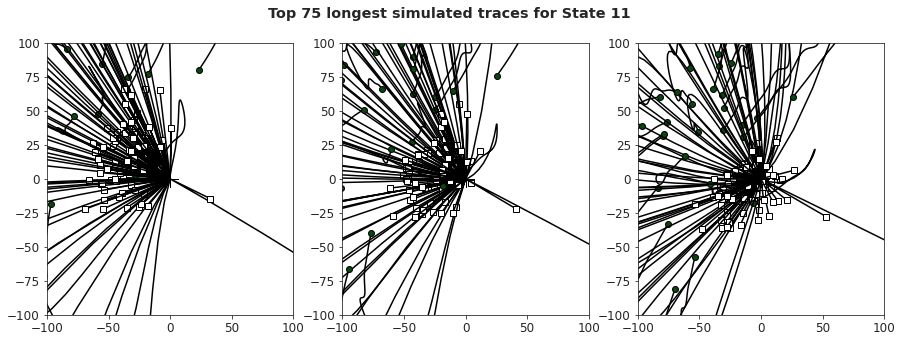

In [26]:
usrplt.plot_example_trajectories(state_duration_list,state_startend_list,data_list, arhmm, simulated=True)

In [ ]:
# Calculate the max state duration for each state on each trial
state_durations_max = np.zeros((nTrials,K))
for iTrial, sd_trial in enumerate(state_duration_list):
    for iState, sd in enumerate(sd_trial[:-1]):
        if len(sd) == 0:
            state_durations_max[iTrial,iState] = 0
        else:
            state_durations_max[iTrial,iState] = np.max(sd)


In [ ]:


# pdfdoc = PdfPages(os.path.join('./plots/','example_trajectories_per-state.pdf'))
nTraces = 75
for iState in range(K):    

    #Get trial indices sorted by state duration for state
    trial_indices = np.argsort(state_durations_max[:,iState],axis=0)[::-1]
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('Top {} longest traces for State {} '.format(nTraces,iState))
    
    #Loop over trials and plot actual traces
    for iTrial in trial_indices[:nTraces]:
        #Get the correct index
        indy = np.argmax(state_duration_list[iTrial][iState])
        iS = state_startend_list[iTrial][iState][indy,0]
        iE = state_startend_list[iTrial][iState][indy,1]-1
        
        #Get data
        data = data_list[iTrial]

        for iPt, ptstr in enumerate(['Nose','LEye','LEar']):
            ax = axes[iPt]
            ax.plot(data[slice(iS,iE),2*iPt],data[slice(iS,iE),2*iPt+1],'-k')#,color=usrplt.cc[iState],lw=2)
            
            ax.plot(data[iS,2*iPt],data[iS,2*iPt+1],'s',color='w',markersize=6,markeredgecolor='k',markeredgewidth=1)#color=usrplt.cc[iState])
            ax.plot(data[iE,2*iPt],data[iE,2*iPt+1],'o',color=usrplt.cc[iState],markersize=6,markeredgecolor='k',markeredgewidth=1)
            ax.plot(0,0,'+k',ms=15)
            ax.set_xlim([-100,100]); ax.set_ylim([-100,100])
            
        
#     plt.show()
#     pdb.set_trace()
#     #Save and close
#     pdfdoc.savefig(fig)
#     plt.close(fig)
# pdfdoc.close()

In [ ]:


# pdfdoc = PdfPages(os.path.join('./plots/','example_trajectories_per-state.pdf'))
nTraces = 75
for iState in range(K):    

    #Get trial indices sorted by state duration for state
    trial_indices = np.argsort(state_durations_max[:,iState],axis=0)[::-1]
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('Top {} longest simulated traces for State {} '.format(nTraces,iState))
    
    #Loop over trials and plot actual traces
    for iTrial in trial_indices[:nTraces]:
        #Get the correct index
        indy = np.argmax(state_duration_list[iTrial][iState])
        nT = np.max(state_duration_list[iTrial][iState])
        iS = state_startend_list[iTrial][iState][indy,0]

        #Get initial starting position and simulate x-trace
        x0 = data_list[iTrial][iS,:]
        data_model = np.zeros((nT,dObs))
        data_model[0,:] = x0; pad = 0
        tmp_stateseq = np.repeat(iState,nT)
        for iT in range(1,nT):
            data_model[iT,:] = arhmm.observations.sample_x(tmp_stateseq[iT], data_model[:iT,:],input = np.zeros((nT+pad,)), with_noise=False)
            
        for iPt, ptstr in enumerate(['Nose','LEye','LEar']):
            ax = axes[iPt]
            ax.plot(data_model[:,2*iPt],data_model[:,2*iPt+1],'-k')#,color=usrplt.cc[iState],lw=2)
            
            ax.plot(data_model[0,2*iPt],data_model[0,2*iPt+1],'s',color='w',markersize=6,markeredgecolor='k',markeredgewidth=1)#color=usrplt.cc[iState])
            ax.plot(data_model[nT-1,2*iPt],data_model[nT-1,2*iPt+1],'o',color=usrplt.cc[iState],markersize=6,markeredgecolor='k',markeredgewidth=1)
            ax.plot(0,0,'+k',ms=15)
            ax.set_xlim([-100,100]); ax.set_ylim([-100,100])
            
        
#     plt.show()
#     pdb.set_trace()
#     #Save and close
#     pdfdoc.savefig(fig)
#     plt.close(fig)
# pdfdoc.close()

In [ ]:
plt.figure(figsize = (8,8))
plt.title('State Transition Matrix for ARHMM')

#Plot heatmap without diagonal; just place annotated transition probabilities there
transition_matrix = arhmm.transitions.transition_matrix
diag_trans_matrix = np.zeros((K,K)); diag_trans_matrix[:] = np.nan
diag_trans_matrix[np.diag_indices(K)] = np.diag(transition_matrix)
transition_matrix[np.diag_indices(K)] = np.nan

# sns.heatmap(transition_matrix,square=True,cbar=True,vmin=0,vmax=np.max(transition_matrix[:]))
# sns.heatmap(diag_trans_matrix,square=True,annot=True,cbar=True,vmin=0,vmax=np.max(transition_matrix[:]),cbar_kws={'shrink':0.5})

In [ ]:
sns.heatmap(transition_matrix,square=True,cbar=True,vmin=0,vmax=np.max(transition_matrix[:]))

In [ ]:
len(MAP_list_sorted[100])

In [ ]:
max_trial_length = len(MAP_list_sorted[100])

#Let's look at the 500 longest state sequences together in a 
zs = np.zeros((200,max_trial_length)); zs[:] = np.nan

for iTrial in range(200):
    indy = np.where(mask_list_sorted[iTrial+100])
    mapseq = MAP_list_sorted[iTrial+100]
    nT = len(mapseq);indy = np.arange(nT)
    zs[iTrial,indy] = mapseq


In [ ]:
trial_lengths = np.array([len(data) for data in data_list])

fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(trial_lengths,ax=ax)
ax.set_xlim(xmax=2000)
xticks = np.arange(-300,2101,300)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks/60)
ax.set_xlabel('Trial Length (s)')


In [ ]:
np.max(trial_lengths)/60

In [ ]:
indy = np.argsort(trial_lengths[trial_indices],kind='stable')[::-1]
trial_lengths[trial_indices[indy]]
indy

In [ ]:
nTraces = 100
for iState in range(K):    

    #Get trial indices sorted by state duration for this state
    trial_indices = np.argsort(state_durations_max[:,iState],axis=0)[::-1]
    trial_lengths_sd = trial_lengths[trial_indices]
    
    #Also sort trials by trial length
    indy = np.argsort(trial_lengths)[::-1]
    
    #Get the trials that are less than 10seconds
    pos = np.where(trial_lengths[indy] < 600)
    
    
    test = trial_indices[indy[pos]]
    pdb.set_trace()
    
    
    
    
    
    max_trial_length = np.max([len(MAP_list[iT]) for iT in trial_indices[:nTraces]])

    #Let's look at the 500 longest state sequences together in a 
    zs = np.zeros((nTraces,max_trial_length)); zs[:] = np.nan
    
    #Loop over trials and get MAPseq
    for ii,iTrial in enumerate(trial_indices[:nTraces]):
        indy = np.arange(0,len(MAP_list[iTrial]))
        zs[ii,indy] = MAP_list[iTrial]
        
    fig, ax = plt.subplots(figsize=(10,5))
    
    plt.imshow(zs,cmap=cmap)
    
    plt.show()
    pdb.set_trace()

In [ ]:
ii

In [ ]:
iTrial = 0
mapseq = MAP_list[iTrial]
data = data_list[iTrial]

nT,_ = data.shape

fig, axes = plt.subplots(2,3,figsize=(15,10),sharex='all', sharey='all' )

#Plot actual traces 
for jj,ptstr in enumerate(['Nose','LEye','LEar']):
    ax = axes[0,jj]
    ax.set_title('Side {}'.format(ptstr))
    ax.plot(data[:,jj*2],data[:,jj*2+1],'-',color=usrplt.cc[-1])
    for state in np.unique(mapseq):
        indy = np.where(mapseq == state)[0]
        #Plot traces
        ax.plot(data[indy,jj*2],data[indy,jj*2+1],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data[0,jj*2],data[0,jj*2+1],'s',color='w',markersize=6,markeredgecolor='k',markeredgewidth=1)
    ax.plot(0,0,'+k',ms=20)

# start_state = (np.array([4],dtype=int),mean_initial_position.reshape(1,dObs))
start_state = (mapseq[:1],data[:1,:])
z_sim, data_sim = arhmm.sample(nT,prefix=start_state,with_noise=False)

#Plot simulated traces
for jj,ptstr in enumerate(['Nose','LEye','LEar']):
    ax = axes[1,jj]
    ax.set_title('Side {}'.format(ptstr))
    
    ax.plot(data_sim[:,jj*2],data_sim[:,jj*2+1],'-',color=usrplt.cc[-1])
    for state in np.unique(z_sim):
        indy = np.where(z_sim == state)[0]
        #Plot traces
        ax.plot(data_sim[indy,jj*2],data_sim[indy,jj*2+1],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data_sim[0,jj*2],data_sim[0,jj*2+1],'s',color='w',markersize=6,markeredgecolor='k',markeredgewidth=1)
    ax.plot(0,0,'+k',ms=20)

# plt.savefig('./plots/simulated-vs-actual_trajectories_trial{:03d}.png'.format(iTrial))


In [ ]:
iTrial = 19
mapseq = MAP_list[iTrial]
data = data_list[iTrial]

nT,_ = data.shape



fig, axes = plt.subplots(2,3,figsize=(15,10),sharex='all', sharey='all' )

#Plot actual traces 
for jj,ptstr in enumerate(['Nose','LEye','LEar']):
    ax = axes[0,jj]
    ax.set_title('Side {}'.format(ptstr))
    ax.plot(data[:,jj*2],data[:,jj*2+1],'-',color=usrplt.cc[-1])
    for state in np.unique(mapseq):
        indy = np.where(mapseq == state)[0]
        #Plot traces
        ax.plot(data[indy,jj*2],data[indy,jj*2+1],'.',color=usrplt.cc[state],ms=10)

    ax.plot(0,0,'+k',ms=20)


#Instead of using the model - transition matrix + AR matrices - to evolve from a starting position and state,
#let's take the state sequence that was determined for a given trial and just sample the observations
data_model = np.zeros(data.shape)
data_model[0,:] = data[0,:]; pad = 0
for iT in range(1,nT):
    data_model[iT,:] = arhmm.observations.sample_x(mapseq[iT], data_model[:iT,:],input = np.zeros((nT+pad,)), with_noise=False)
    
#Plot simulated traces
for jj,ptstr in enumerate(['Nose','LEye','LEar']):
    ax = axes[1,jj]
    ax.set_title('Side {}'.format(ptstr))
    ax.plot(data_model[:,jj*2],data_model[:,jj*2+1],'-',color=usrplt.cc[-1])
    for state in np.unique(mapseq):
        indy = np.where(mapseq == state)[0]
        #Plot traces
        ax.plot(data_model[indy,jj*2],data_model[indy,jj*2+1],'.',color=usrplt.cc[state],ms=10)

    ax.plot(0,0,'+k',ms=20)

# plt.savefig('./plots/simulated-vs-actual_trajectories_trial{:03d}.png'.format(iTrial))


In [ ]:
np.pi*12